# Plankton image classification

## Context
The RV Cefas Endeavour, a multi-disciplinary research vessel, collects millions of mesozooplankton (size range 0.2-20 mm) images during its surveys through the Plankton Imager (PI) system: a high-speed imaging instrument which continuously pumps water, takes images of the passing particles, and attempts to identifies the zooplankton organisms present. Images have varying shapes and sizes with a highly-skewed distribution towards smaller particles/images (see Figure 1). Of these, over 80% can be classified as detritus (e.g., sand, seaweed fragments, microplastics) which are traditionally removed by-eye before any analysis, leaving the remaining plankton images to be manually labelled.

<img src="./figs/fig1.png" width="600">

**Figure 1** Mesozooplankton imaged by the PI system. Source: Pitois (2021).

The challenge for computer vision methods is to automatically classify collected images or other plankton image databases alike at finer taxonomic levels (species) or coarser groups (copepod and non-copepod) and also discern them from detritus.

<div class="alert alert-block alert-info">
In this notebook, we'll walk through how scivision can assist in discovering a pretrained ResNet50 model, generated during a Data Study Group (DSG) challenge, and then use it to classify a small plankton image dataset in three classes: copepod, non-copepod and detritus.
    
Further details of the DSG challenge can be found in [the original model repository](https://github.com/alan-turing-institute/plankton-dsg-challenge) and the [DSG report](https://www.turing.ac.uk/research/publications/data-study-group-final-report-centre-environment-fisheries-and-aquaculture).
</div>

## Load libraries

To get started, let's first load `scivision` modules and plotting libraries relevant to this notebook.

In [1]:
from scivision.catalog import default_catalog
from scivision.io import load_dataset, load_pretrained_model
import matplotlib.pyplot as plt

## Catalog

We'll use the ResNet-50 CEFAS plankton model which is registered in the scivision model catalog as `resnet50-plantkton`. Then we'll look with `compatible_datasources` potential data entries registered in the scivision data catalog with tasks and format compatible with the model.

In [2]:
model_name = 'resnet50-plantkton'

In [3]:
compatible_datasources = default_catalog.compatible_datasources(model_name).to_dataframe()

This returns a `pandas.dataframe` with the number of potential datasets to pair the model with.

In [4]:
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
2,data-002,None,"(TaskEnum.classificiation,)","(oceanography,)",https://github.com/scotthosking/intake-plankto...,image,True,"(CEFAS,)","(help-needed, 2D)"
4,data-004,Sample dataset of Plankton required to demonst...,"(TaskEnum.classificiation,)","(computer-vision,)",https://raw.githubusercontent.com/alan-turing-...,image,True,"(Centre for Environment, Fisheries and Aquacul...","(2D, plankton, ecology, environmental-science)"


## Model

The following lines will look for the model URL (in this case the GitHub repository) from the scivision model catalog. After, the `load_pretrained_model` function will recognise the URL and install dependencies if they are not yet in the current virtual environment.

In [5]:
models = default_catalog.models.to_dataframe()
targetmodel = models[models.name == model_name].url.item()
model = load_pretrained_model(targetmodel, allow_install=True)

Let's explore the configurations (source, expected input and outputs) of the loaded model.

In [6]:
model

scivision.PretrainedModel( 
  module='resnet50_cefas', 
  model='resnet50', 
  source='https://github.com/alan-turing-institute/plankton-cefas-scivision' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Data

We'll load one of the suggested datasets in `compatible_datasources`. In this case, we will use the dataset registered with the `name` field equals to `data-004`. This refers to a small sample dataset kindly prepared by CEFAS to demonstrate the ResNet50 model.

In [7]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-004']
target_datasource

,name,description,tasks,domains,url,format,labels_provided,institution,tags
4,data-004,Sample dataset of Plankton required to demonst...,"(TaskEnum.classificiation,)","(computer-vision,)",https://raw.githubusercontent.com/alan-turing-...,image,True,"(Centre for Environment, Fisheries and Aquacul...","(2D, plankton, ecology, environmental-science)"


In [8]:
cat = load_dataset(target_datasource.url.item()) 
dataset = cat.plankton().to_dask()

In `dataset`, all images are stacked into a single `xarray.Dataset` object with a defined dimension, in this case 1000 px x 1000 px. The size was predefined in the configuration file of the data source. 

In [9]:
dataset

<xarray.Dataset>
Dimensions:                               (concat_dim: 26, y: 1000, x: 1000,
                                           channel: 3)
Coordinates:
  * concat_dim                            (concat_dim) int64 0 1 2 ... 23 24 25
  * y                                     (y) int64 0 1 2 3 ... 996 997 998 999
  * x                                     (x) int64 0 1 2 3 ... 996 997 998 999
  * channel                               (channel) int64 0 1 2
Data variables: (12/23)
    raster                                (concat_dim, y, x, channel) uint8 dask.array<chunksize=(1, 1000, 1000, 3), meta=np.ndarray>
    EXIF Image ImageWidth                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image ImageLength                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image BitsPerSample              (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image Compression                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image PhotometricInterpretation  (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                    ...
    EXIF GPS GPSVersionID                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF GPS GPSLatitudeRef               (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF GPS GPSLatitude                  (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF GPS GPSLongitudeRef              (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF GPS GPSLongitude                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image GPSInfo                    (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>

Let's inspect and visualise the first object in `dataset`. The observed image background is generated when stacking all sample images into a `xarray.Dataset` object.

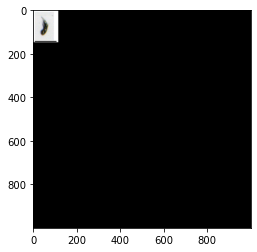

In [10]:
subset = dataset.sel(concat_dim=0)
plt.imshow(subset['raster'].compute().values[:,:,:])
plt.show()

## Prediction and visualisation

Once we load model and data, we will use the `predict` function previously defined within the scivision configuration file of the model. In this example, the `predict` function goes over the complete set of sample images and classify all of them in a single pass. For larger datasets, the user can also predict in batches using the `batch_size` argument.

Possibly corrupted field Model in Image IFD
Possibly corrupted field GPSLongitudeRef in GPS IFD
Possibly corrupted field GPSLongitudeRef in GPS IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field GPSLongitudeRef in GPS IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field GPSLongitudeRef in GPS IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field GPSLongitudeRef in GPS IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field Model in Image IFD
Possibly corrupted field GPSLongitudeRef in GPS IFD
Possibly corrupted field Model in Image IFD


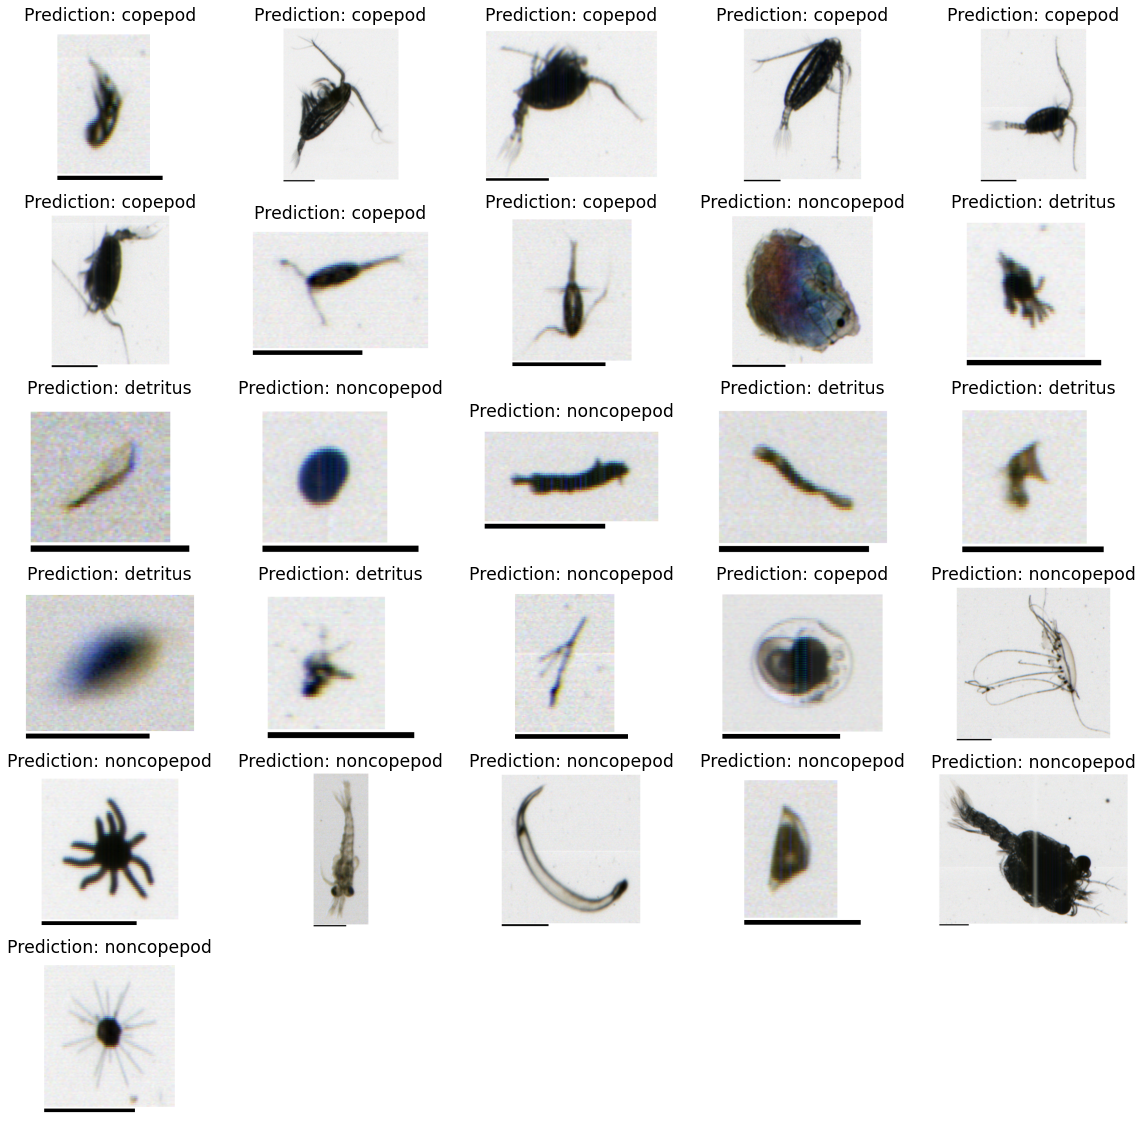

In [11]:
y = model.predict(dataset, batch_size=26)